In [5]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1,activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#model.summary()

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [24]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'
train_horses_dir = os.path.join(train_dir,'horses')
train_humans_dir = os.path.join(train_dir,'humans')
validation_horses_dir = os.path.join(validation_dir,'horses')
validation_humans_dir = os.path.join(validation_dir,'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

In [25]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [35]:
my_callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
50/50 - 10s - loss: 0.0254 - accuracy: 0.9929 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 2/20
50/50 - 10s - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0060 - val_accuracy: 0.9950
Epoch 3/20
50/50 - 10s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.9013e-05 - val_accuracy: 1.0000
Epoch 4/20
50/50 - 10s - loss: 0.0111 - accuracy: 0.9959 - val_loss: 3.2032e-04 - val_accuracy: 1.0000
Epoch 5/20
50/50 - 10s - loss: 3.5454e-04 - accuracy: 1.0000 - val_loss: 2.1415e-04 - val_accuracy: 1.0000
Epoch 6/20
50/50 - 10s - loss: 6.3036e-04 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9950
Epoch 7/20
50/50 - 10s - loss: 0.0094 - accuracy: 0.9980 - val_loss: 0.0071 - val_accuracy: 0.9950
Epoch 8/20
50/50 - 10s - loss: 4.4993e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 9/20
50/50 - 10s - loss: 0.0130 - accuracy: 0.9949 - val_loss: 2.5987e-05 - val_accuracy: 1.0000
Epoch 10/20
50/50 - 10s - loss: 6.0693e-04 - accuracy: 1.0000 - val_loss: 0.0052 

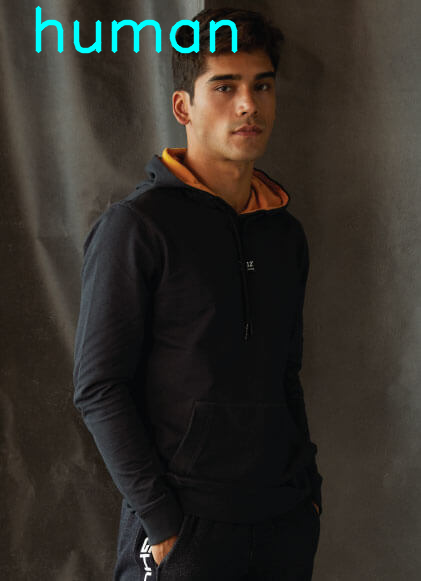

In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_img = image.load_img('/BH_1.jpg',target_size=(150,150))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img,axis=0)
result = model.predict(test_img)
if result[0][0]==1:
  prediction = 'human'
else:
  prediction = 'horse'
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('/BH_1.jpg')
#newImg = cv2.resize(image, (0,0), fx=0.3, fy=0.3)
newImg = cv2.putText(image,prediction,(30,50),cv2.FONT_HERSHEY_SIMPLEX,
                     2,(255, 255, 0),4,cv2.LINE_AA)
cv2_imshow(newImg)